# Assignment 2: Training and Visualizing a CNN on CIFAR-10
**Framework:** TensorFlow / Keras  
**Dataset:** CIFAR-10  
**Tasks:** CNN Design & Training | Feature Map Visualization | Maximally Activating Images

## Cell 1 — Imports & Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# CIFAR-10 class names
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f'TensorFlow version: {tf.__version__}')
print(f'GPU available: {len(tf.config.list_physical_devices("GPU")) > 0}')

TensorFlow version: 2.19.0
GPU available: True


---
## Task 1: CNN Design and Training
### Cell 2 — Load & Preprocess CIFAR-10

In [2]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# Flatten labels
y_train = y_train.flatten()
y_test  = y_test.flatten()

# Create a small validation split (10% of training data)
val_split = int(0.1 * len(x_train))
x_val, y_val = x_train[:val_split], y_train[:val_split]
x_train, y_train = x_train[val_split:], y_train[val_split:]

print(f'Training   samples: {x_train.shape[0]}')
print(f'Validation samples: {x_val.shape[0]}')
print(f'Test       samples: {x_test.shape[0]}')
print(f'Image shape: {x_train.shape[1:]}')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Training   samples: 45000
Validation samples: 5000
Test       samples: 10000
Image shape: (32, 32, 3)


### Cell 3 — Data Augmentation

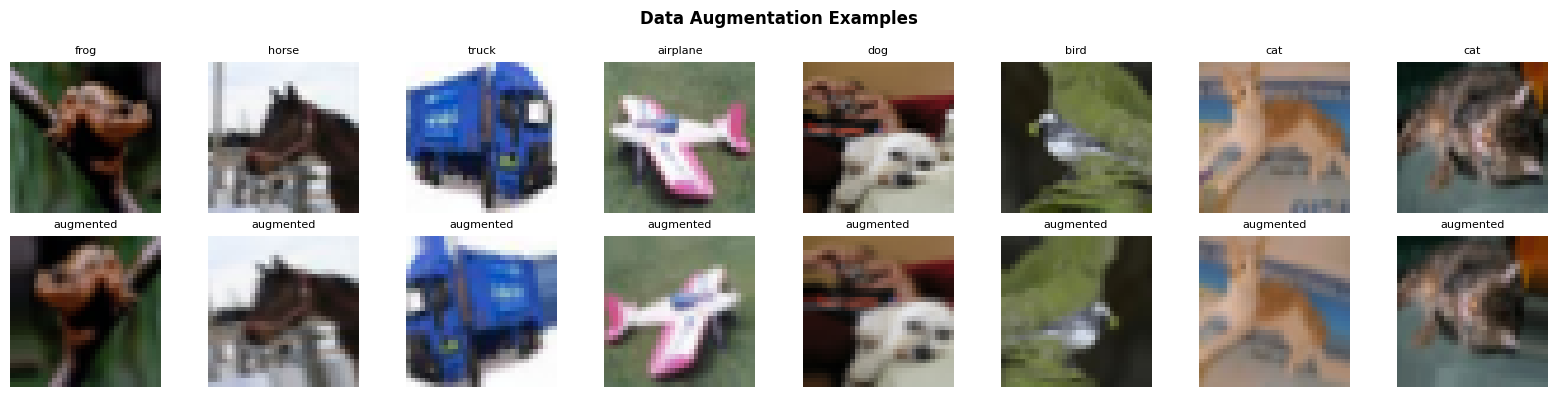

Augmentation figure saved.


In [3]:
# Data augmentation using ImageDataGenerator
# Applied ONLY to training data to reduce overfitting
datagen = ImageDataGenerator(
    horizontal_flip=True,          # randomly flip images left-right
    width_shift_range=0.1,         # randomly shift images horizontally
    height_shift_range=0.1,        # randomly shift images vertically
    rotation_range=15,             # randomly rotate images up to 15 degrees
    zoom_range=0.1                 # randomly zoom in/out
)
datagen.fit(x_train)

# Visualize a few augmented samples
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
sample_imgs = x_train[:8]
sample_lbls = y_train[:8]

for i in range(8):
    axes[0, i].imshow(sample_imgs[i])
    axes[0, i].set_title(CLASS_NAMES[sample_lbls[i]], fontsize=8)
    axes[0, i].axis('off')

aug_iter = datagen.flow(sample_imgs, batch_size=8, shuffle=False)
aug_batch = next(aug_iter)
for i in range(8):
    axes[1, i].imshow(np.clip(aug_batch[i], 0, 1))
    axes[1, i].set_title('augmented', fontsize=8)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=10)
axes[1, 0].set_ylabel('Augmented', fontsize=10)
plt.suptitle('Data Augmentation Examples', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('augmentation_examples.png', dpi=150, bbox_inches='tight')
plt.show()
print('Augmentation figure saved.')

### Cell 4 — CNN Architecture

**Architecture Summary:**
- **Block 1:** Conv2D(32) → BN → ReLU → Conv2D(32) → BN → ReLU → MaxPool → Dropout(0.25)
- **Block 2:** Conv2D(64) → BN → ReLU → Conv2D(64) → BN → ReLU → MaxPool → Dropout(0.25)
- **Block 3:** Conv2D(128) → BN → ReLU → Conv2D(128) → BN → ReLU → MaxPool → Dropout(0.25)
- **Head:**    Flatten → Dense(256) → BN → ReLU → Dropout(0.5) → Dense(10, softmax)

In [4]:
def build_cnn(input_shape=(32, 32, 3), num_classes=10):
    """
    Custom CNN for CIFAR-10 classification.

    Architecture:
      3 convolutional blocks (each with 2 conv layers + batch norm + max pooling + dropout)
      1 fully connected classification head

    Regularization: Batch Normalization + Dropout
    Activation: ReLU throughout (softmax on output layer)
    """
    inputs = keras.Input(shape=input_shape, name='input')

    # ── Block 1 ─────────────────────────────────────────────
    x = layers.Conv2D(32, (3, 3), padding='same', name='conv1_1')(inputs)
    x = layers.BatchNormalization(name='bn1_1')(x)
    x = layers.Activation('relu', name='relu1_1')(x)

    x = layers.Conv2D(32, (3, 3), padding='same', name='conv1_2')(x)
    x = layers.BatchNormalization(name='bn1_2')(x)
    x = layers.Activation('relu', name='relu1_2')(x)

    x = layers.MaxPooling2D((2, 2), name='pool1')(x)     # 32x32 -> 16x16
    x = layers.Dropout(0.25, name='drop1')(x)

    # ── Block 2 ─────────────────────────────────────────────
    x = layers.Conv2D(64, (3, 3), padding='same', name='conv2_1')(x)
    x = layers.BatchNormalization(name='bn2_1')(x)
    x = layers.Activation('relu', name='relu2_1')(x)

    x = layers.Conv2D(64, (3, 3), padding='same', name='conv2_2')(x)
    x = layers.BatchNormalization(name='bn2_2')(x)
    x = layers.Activation('relu', name='relu2_2')(x)

    x = layers.MaxPooling2D((2, 2), name='pool2')(x)     # 16x16 -> 8x8
    x = layers.Dropout(0.25, name='drop2')(x)

    # ── Block 3 ─────────────────────────────────────────────
    x = layers.Conv2D(128, (3, 3), padding='same', name='conv3_1')(x)
    x = layers.BatchNormalization(name='bn3_1')(x)
    x = layers.Activation('relu', name='relu3_1')(x)

    x = layers.Conv2D(128, (3, 3), padding='same', name='conv3_2')(x)
    x = layers.BatchNormalization(name='bn3_2')(x)
    x = layers.Activation('relu', name='relu3_2')(x)

    x = layers.MaxPooling2D((2, 2), name='pool3')(x)     # 8x8 -> 4x4
    x = layers.Dropout(0.25, name='drop3')(x)

    # ── Classification Head ──────────────────────────────────
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(256, name='fc1')(x)
    x = layers.BatchNormalization(name='bn_fc')(x)
    x = layers.Activation('relu', name='relu_fc')(x)
    x = layers.Dropout(0.5, name='drop_fc')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

    model = keras.Model(inputs, outputs, name='CIFAR10_CNN')
    return model


model = build_cnn()
model.summary()

Model: "CIFAR10_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_1 (Activation)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 32, 32, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_2 (Activation)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_1 (Activation)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 16, 16, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_2 (Activation)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 8, 8, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_1 (Activation)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 8, 8, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_2 (Activation)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 4, 4, 128)      │             

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

### Cell 5 — Compile & Train

In [5]:
# ── Training Hyperparameters ──────────────────────────────
LEARNING_RATE = 0.001
BATCH_SIZE    = 64
EPOCHS        = 50

# ── Compile ───────────────────────────────────────────────
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),  # Adam optimizer
    loss='sparse_categorical_crossentropy',                         # multi-class cross-entropy
    metrics=['accuracy']
)

# ── Callbacks ─────────────────────────────────────────────
callbacks = [
    # Reduce LR by factor of 0.5 if val_loss doesn't improve for 5 epochs
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5,
                      min_lr=1e-6, verbose=1),
    # Stop training early if val_loss doesn't improve for 10 epochs
    EarlyStopping(monitor='val_loss', patience=10,
                  restore_best_weights=True, verbose=1)
]

print('=== Training Configuration ===')
print(f'  Loss function : Sparse Categorical Cross-Entropy')
print(f'  Optimizer     : Adam')
print(f'  Learning rate : {LEARNING_RATE}')
print(f'  Batch size    : {BATCH_SIZE}')
print(f'  Max epochs    : {EPOCHS}')
print(f'  Regularization: BatchNorm + Dropout(0.25/0.5)')
print(f'  Augmentation  : Flip, Shift, Rotation, Zoom')
print(f'  Callbacks     : ReduceLROnPlateau, EarlyStopping')
print('==============================')

# ── Train ─────────────────────────────────────────────────
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

=== Training Configuration ===
  Loss function : Sparse Categorical Cross-Entropy
  Optimizer     : Adam
  Learning rate : 0.001
  Batch size    : 64
  Max epochs    : 50
  Regularization: BatchNorm + Dropout(0.25/0.5)
  Augmentation  : Flip, Shift, Rotation, Zoom
  Callbacks     : ReduceLROnPlateau, EarlyStopping
Epoch 1/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 48s 49ms/step - accuracy: 0.3323 - loss: 1.9226 - val_accuracy: 0.5054 - val_loss: 1.4299 - learning_rate: 0.0010
Epoch 2/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.6719 - loss: 1.0823 - val_accuracy: 0.5042 - val_loss: 1.4245 - learning_rate: 0.0010
Epoch 3/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.5389 - loss: 1.2787 - val_accuracy: 0.6428 - val_loss: 1.0231 - learning_rate: 0.0010
Epoch 4/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.6406 - loss: 1.0937 - val_accuracy: 0.6434 - val_loss: 1.0232 - learning_rate: 0.0010
Epoch 5/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.

### Cell 6 — Evaluate on Test Set

In [6]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'\n=== Final Test Results ===')
print(f'  Test Loss    : {test_loss:.4f}')
print(f'  Test Accuracy: {test_acc*100:.2f}%')
print('==========================')


=== Final Test Results ===
  Test Loss    : 0.4496
  Test Accuracy: 84.98%


### Cell 7 — Training & Validation Loss / Accuracy Curves

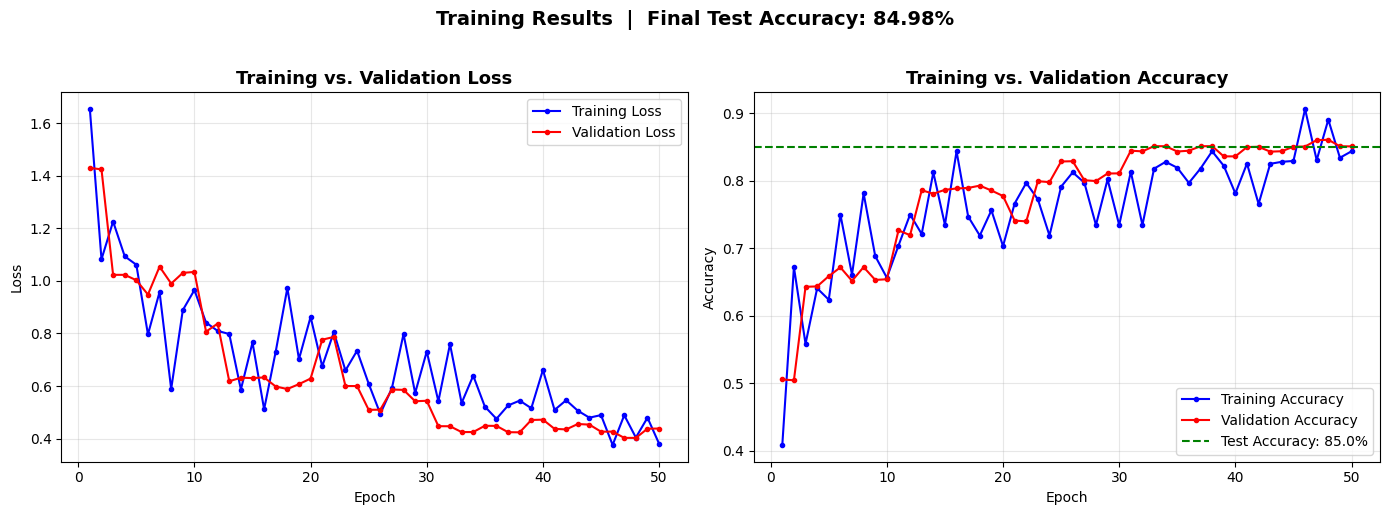

Training curves saved.


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_ran = range(1, len(history.history['loss']) + 1)

# ── Loss curve ────────────────────────────────────────────
axes[0].plot(epochs_ran, history.history['loss'],     'b-o', markersize=3, label='Training Loss')
axes[0].plot(epochs_ran, history.history['val_loss'], 'r-o', markersize=3, label='Validation Loss')
axes[0].set_title('Training vs. Validation Loss', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ── Accuracy curve ────────────────────────────────────────
axes[1].plot(epochs_ran, history.history['accuracy'],     'b-o', markersize=3, label='Training Accuracy')
axes[1].plot(epochs_ran, history.history['val_accuracy'], 'r-o', markersize=3, label='Validation Accuracy')
axes[1].axhline(y=test_acc, color='green', linestyle='--', linewidth=1.5,
                label=f'Test Accuracy: {test_acc*100:.1f}%')
axes[1].set_title('Training vs. Validation Accuracy', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Training Results  |  Final Test Accuracy: {test_acc*100:.2f}%',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('Training curves saved.')

---
## Task 2A — Feature Map Visualization (First Conv Layer)
### Cell 8 — Select 3 Test Images from Different Classes

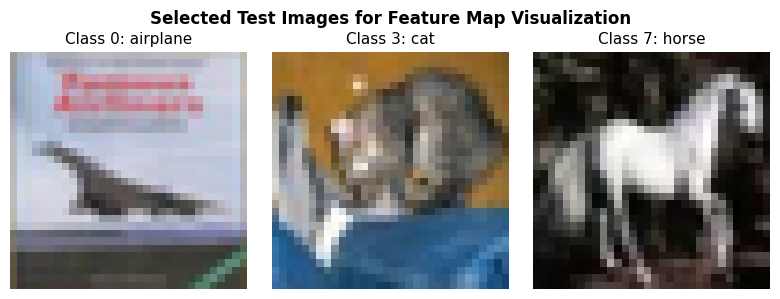

In [8]:
# Select 1 test image per class for 3 different classes
# Classes chosen: airplane (0), cat (3), horse (7)
TARGET_CLASSES = [0, 3, 7]  # airplane, cat, horse

selected_images = []
selected_labels = []

for cls in TARGET_CLASSES:
    idx = np.where(y_test == cls)[0][0]   # first test image of that class
    selected_images.append(x_test[idx])
    selected_labels.append(y_test[idx])

selected_images = np.array(selected_images)   # shape: (3, 32, 32, 3)

# Display the 3 selected images
fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for i, (img, lbl) in enumerate(zip(selected_images, selected_labels)):
    axes[i].imshow(img)
    axes[i].set_title(f'Class {lbl}: {CLASS_NAMES[lbl]}', fontsize=11)
    axes[i].axis('off')
plt.suptitle('Selected Test Images for Feature Map Visualization', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('selected_images.png', dpi=150, bbox_inches='tight')
plt.show()

### Cell 9 — Extract Feature Maps from First Conv Layer

In [9]:
# Build a sub-model that outputs the activation of the first conv layer (after ReLU)
first_relu_output = model.get_layer('relu1_1').output
feature_map_model = keras.Model(inputs=model.input, outputs=first_relu_output)

# Get feature maps for all 3 selected images
feature_maps = feature_map_model.predict(selected_images, verbose=0)
# Shape: (3, 32, 32, 32)  — 3 images, 32x32 spatial, 32 channels

print(f'Feature map tensor shape: {feature_maps.shape}')
print(f'  → {feature_maps.shape[0]} images')
print(f'  → {feature_maps.shape[1]}x{feature_maps.shape[2]} spatial resolution')
print(f'  → {feature_maps.shape[3]} filter channels')

Feature map tensor shape: (3, 32, 32, 32)
  → 3 images
  → 32x32 spatial resolution
  → 32 filter channels


### Cell 10 — Visualize 8 Feature Maps per Image

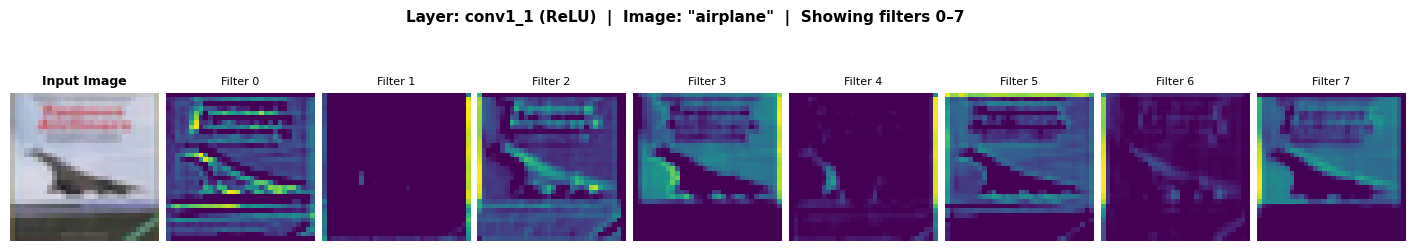

Feature map figure saved for: airplane


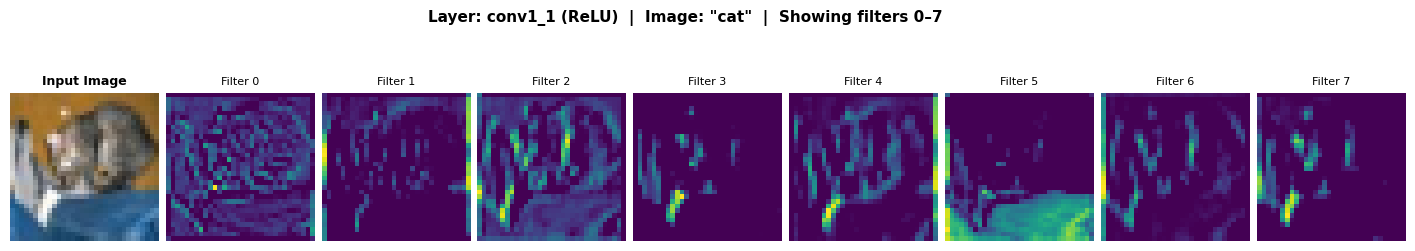

Feature map figure saved for: cat


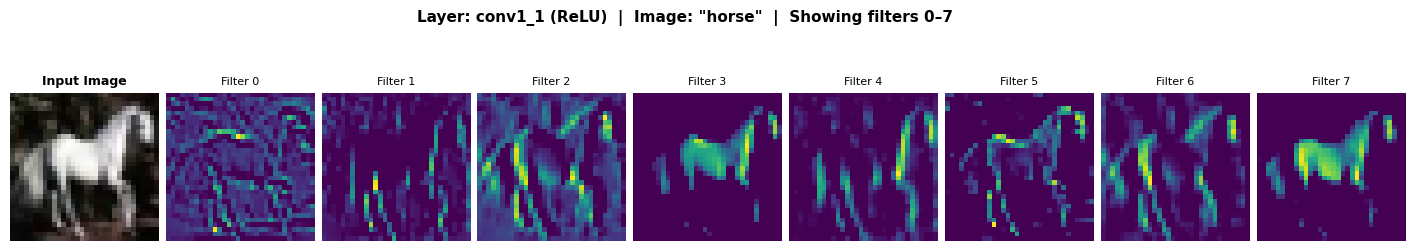

Feature map figure saved for: horse


In [10]:
NUM_FILTERS_TO_SHOW = 8

for img_idx in range(3):
    class_name = CLASS_NAMES[selected_labels[img_idx]]
    fmaps = feature_maps[img_idx]   # shape: (32, 32, 32)

    fig = plt.figure(figsize=(18, 3))
    gs  = gridspec.GridSpec(1, NUM_FILTERS_TO_SHOW + 1, figure=fig,
                            wspace=0.05, hspace=0.1)

    # Original image (first column)
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(selected_images[img_idx])
    ax0.set_title('Input Image', fontsize=9, fontweight='bold')
    ax0.axis('off')

    # Feature maps (columns 1–8)
    for f in range(NUM_FILTERS_TO_SHOW):
        ax = fig.add_subplot(gs[0, f + 1])
        ax.imshow(fmaps[:, :, f], cmap='viridis')
        ax.set_title(f'Filter {f}', fontsize=8)
        ax.axis('off')

    fig.suptitle(
        f'Layer: conv1_1 (ReLU)  |  Image: "{class_name}"  |  '
        f'Showing filters 0–{NUM_FILTERS_TO_SHOW - 1}',
        fontsize=11, fontweight='bold', y=1.02
    )
    plt.savefig(f'feature_maps_{class_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Feature map figure saved for: {class_name}')

### Cell 11 — Filter Weight Visualization (What the Filters Look Like)

conv1_1 kernel shape: (3, 3, 3, 32)


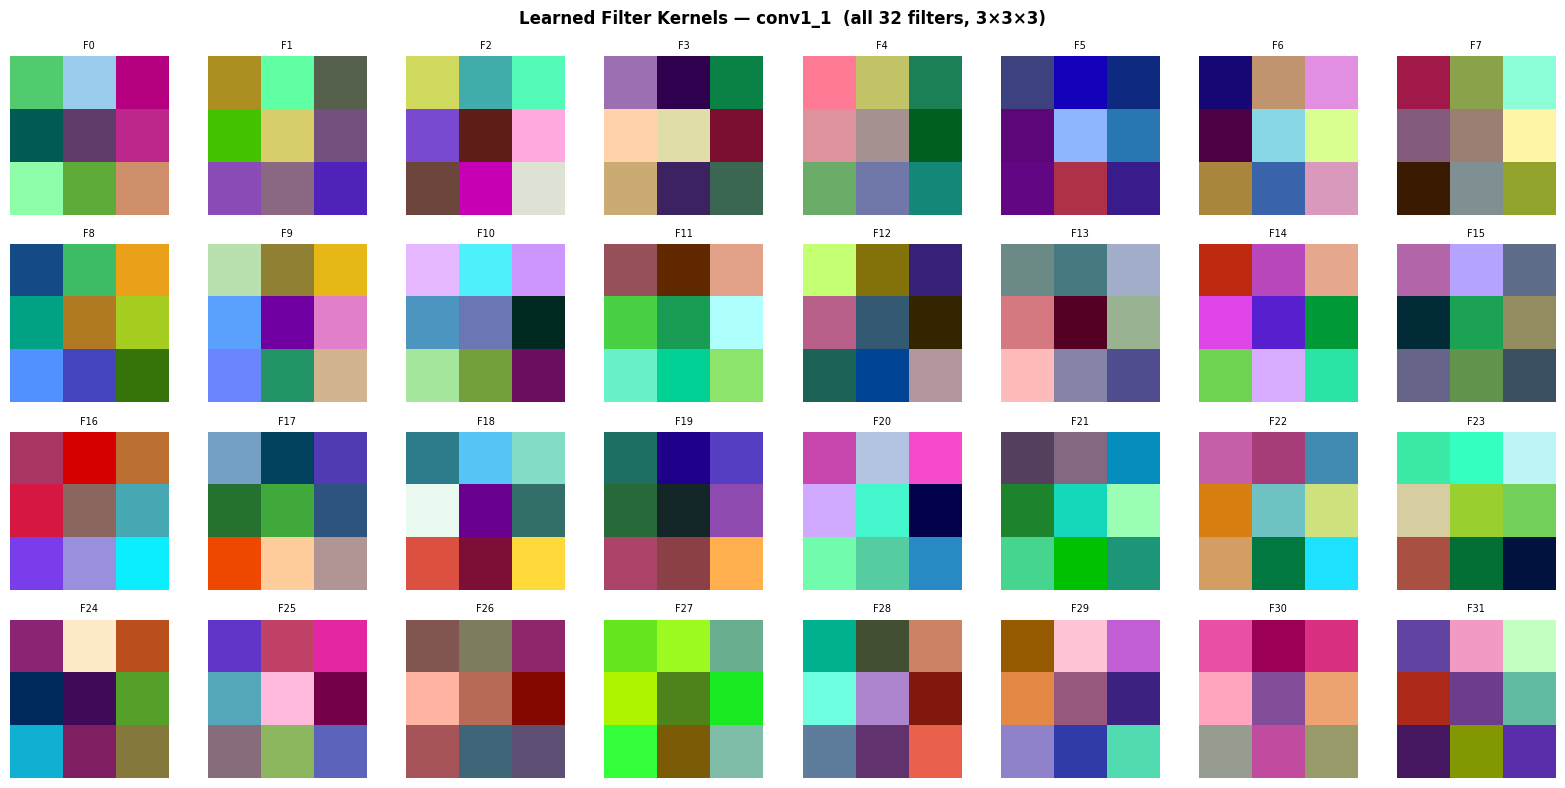

Filter visualization saved.


In [11]:
# Visualize the actual learned filter kernels from conv1_1
conv1_weights = model.get_layer('conv1_1').get_weights()[0]   # shape: (3, 3, 3, 32)
print(f'conv1_1 kernel shape: {conv1_weights.shape}')  # (kH, kW, in_channels, out_channels)

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for f in range(32):
    ax  = axes[f // 8, f % 8]
    kernel = conv1_weights[:, :, :, f]           # shape: (3, 3, 3)
    # Normalize to [0,1] for visualization
    k_min, k_max = kernel.min(), kernel.max()
    kernel_norm = (kernel - k_min) / (k_max - k_min + 1e-8)
    ax.imshow(kernel_norm)
    ax.set_title(f'F{f}', fontsize=7)
    ax.axis('off')

plt.suptitle('Learned Filter Kernels — conv1_1  (all 32 filters, 3×3×3)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('conv1_filters.png', dpi=150, bbox_inches='tight')
plt.show()
print('Filter visualization saved.')

---
## Task 2B — Maximally Activating Images
### Cell 12 — Build Activation Model for a Middle Conv Layer

In [12]:
# Choose layer: conv2_2 (middle layer, after 2nd block's second conv)
# This layer has richer, more structured features than conv1
CHOSEN_LAYER = 'relu2_2'
CHOSEN_FILTERS = [0, 10, 25]   # 3 filters to analyze
ACTIVATION_METHOD = 'mean'      # 'mean' or 'max' — we use mean (overall response strength)

activation_model = keras.Model(
    inputs=model.input,
    outputs=model.get_layer(CHOSEN_LAYER).output
)

print(f'Chosen layer  : {CHOSEN_LAYER}')
print(f'Chosen filters: {CHOSEN_FILTERS}')
print(f'Activation def: {ACTIVATION_METHOD} of the 2D feature map')

Chosen layer  : relu2_2
Chosen filters: [0, 10, 25]
Activation def: mean of the 2D feature map


### Cell 13 — Compute Activation Scores for All Test Images

In [13]:
# Run ALL test images through the activation model in batches
print(f'Computing activations for all {len(x_test)} test images...')

BATCH = 256
all_activations = []

for start in range(0, len(x_test), BATCH):
    batch = x_test[start:start + BATCH]
    act   = activation_model.predict(batch, verbose=0)   # (B, H, W, C)
    all_activations.append(act)

all_activations = np.concatenate(all_activations, axis=0)  # (10000, H, W, C)
print(f'Activation tensor shape: {all_activations.shape}')

# Reduce each feature map to a scalar per filter using MEAN
# Shape: (num_images, num_filters)
if ACTIVATION_METHOD == 'mean':
    scalar_activations = all_activations.mean(axis=(1, 2))   # mean over H, W
else:
    scalar_activations = all_activations.max(axis=(1, 2))    # max over H, W

print(f'Scalar activations shape: {scalar_activations.shape}')
print(f'Activation method used  : {ACTIVATION_METHOD}')

Computing activations for all 10000 test images...
Activation tensor shape: (10000, 16, 16, 64)
Scalar activations shape: (10000, 64)
Activation method used  : mean


### Cell 14 — Find Top-5 Images per Filter & Visualize

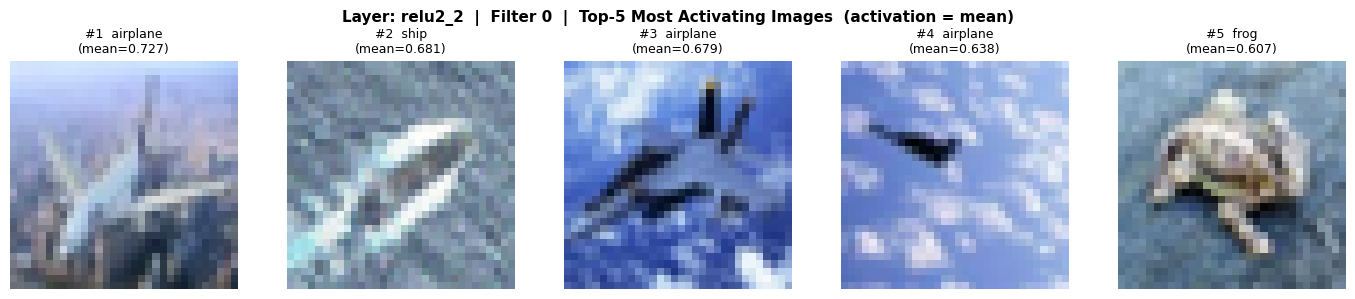

Filter 0: top classes = ['airplane', 'ship', 'airplane', 'airplane', 'frog']
             scores  = ['0.727', '0.681', '0.679', '0.638', '0.607']



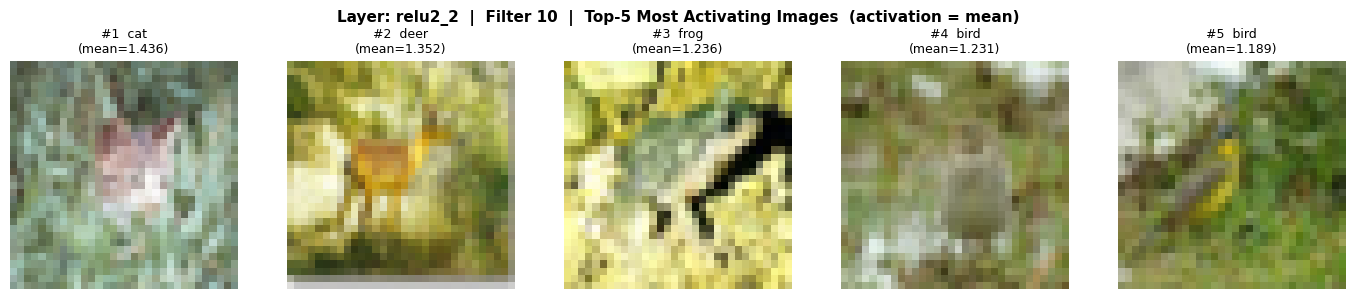

Filter 10: top classes = ['cat', 'deer', 'frog', 'bird', 'bird']
             scores  = ['1.436', '1.352', '1.236', '1.231', '1.189']



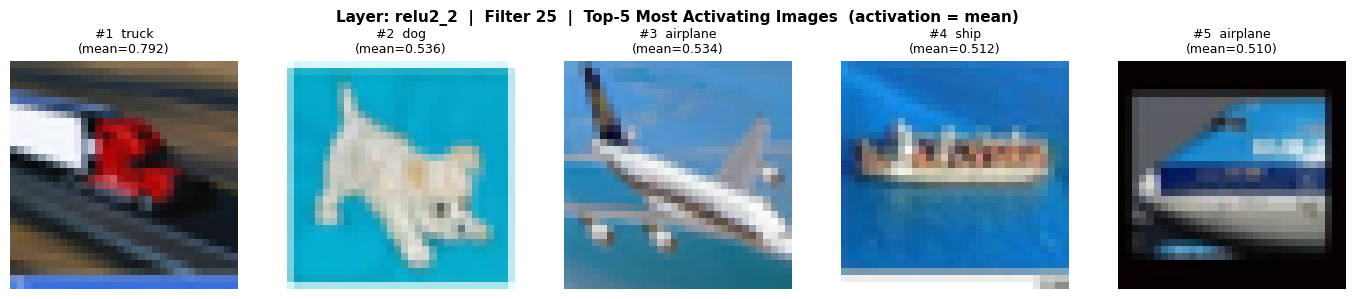

Filter 25: top classes = ['truck', 'dog', 'airplane', 'ship', 'airplane']
             scores  = ['0.792', '0.536', '0.534', '0.512', '0.510']



In [14]:
TOP_K = 5

for filt_idx in CHOSEN_FILTERS:
    # Get activation scores for this filter across all images
    filter_scores = scalar_activations[:, filt_idx]  # shape: (10000,)

    # Sort descending and take top-5
    top5_indices = np.argsort(filter_scores)[::-1][:TOP_K]
    top5_scores  = filter_scores[top5_indices]
    top5_labels  = y_test[top5_indices]

    fig, axes = plt.subplots(1, TOP_K, figsize=(14, 3))
    for rank, (img_idx, score, label) in enumerate(
            zip(top5_indices, top5_scores, top5_labels)):
        axes[rank].imshow(x_test[img_idx])
        axes[rank].set_title(
            f'#{rank+1}  {CLASS_NAMES[label]}\n({ACTIVATION_METHOD}={score:.3f})',
            fontsize=9
        )
        axes[rank].axis('off')
        # Highlight rank with a colored border
        for spine in axes[rank].spines.values():
            spine.set_edgecolor('gold')
            spine.set_linewidth(3)

    fig.suptitle(
        f'Layer: {CHOSEN_LAYER}  |  Filter {filt_idx}  |  '
        f'Top-{TOP_K} Most Activating Images  (activation = {ACTIVATION_METHOD})',
        fontsize=11, fontweight='bold'
    )
    plt.tight_layout()
    plt.savefig(f'max_activating_filter{filt_idx}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Filter {filt_idx}: top classes = {[CLASS_NAMES[l] for l in top5_labels]}')
    print(f'             scores  = {[f"{s:.3f}" for s in top5_scores]}')
    print()

### Cell 15 — Per-Class Activation Heatmap for Each Filter

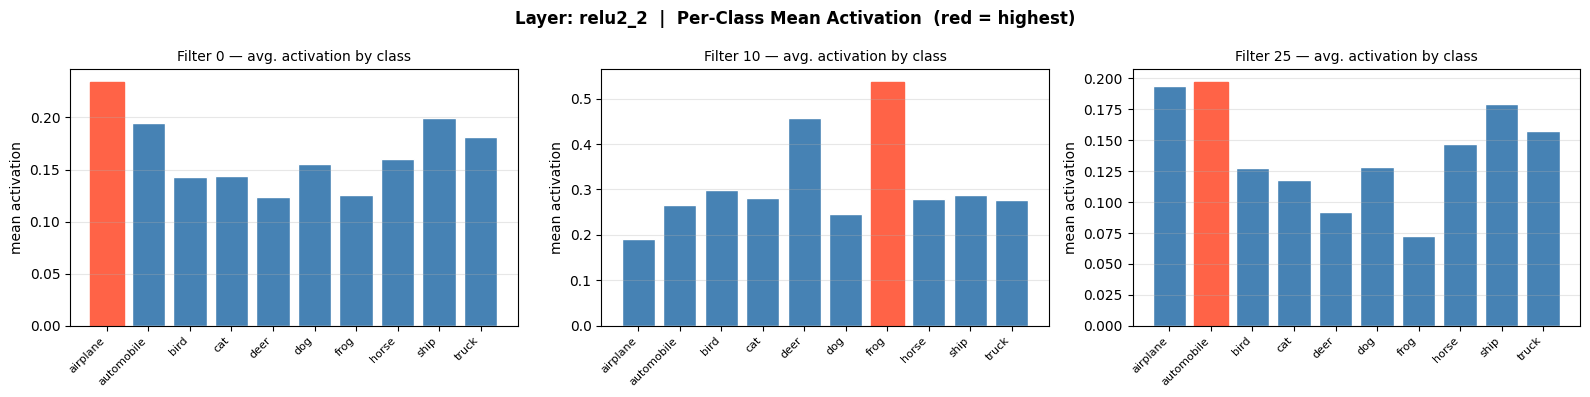

Per-class activation chart saved.


In [15]:
# Bar chart: average activation per class for each chosen filter
fig, axes = plt.subplots(1, len(CHOSEN_FILTERS), figsize=(16, 4))

for ax, filt_idx in zip(axes, CHOSEN_FILTERS):
    filter_scores = scalar_activations[:, filt_idx]
    class_means   = [filter_scores[y_test == c].mean() for c in range(10)]

    bars = ax.bar(CLASS_NAMES, class_means, color='steelblue', edgecolor='white')
    # Highlight the top class
    top_cls = int(np.argmax(class_means))
    bars[top_cls].set_color('tomato')

    ax.set_title(f'Filter {filt_idx} — avg. activation by class', fontsize=10)
    ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel(f'{ACTIVATION_METHOD} activation')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle(f'Layer: {CHOSEN_LAYER}  |  Per-Class Mean Activation  (red = highest)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('per_class_activation.png', dpi=150, bbox_inches='tight')
plt.show()
print('Per-class activation chart saved.')

---
## Summary
### Cell 16 — Print Full Summary for Report

In [16]:
print('=' * 55)
print('         ASSIGNMENT 2 — FINAL SUMMARY')
print('=' * 55)
print()
print('── Model Architecture ──────────────────────────────')
print('  Custom CNN, no pretrained weights')
print('  6 Conv layers (2 per block × 3 blocks)')
print('  3 MaxPooling layers  (2×2, stride 2)')
print('  ReLU activations throughout')
print('  BatchNorm after every Conv & Dense layer')
print('  Dropout: 0.25 after each pool; 0.5 before output')
print('  FC head: Dense(256) → Dense(10, softmax)')
print()
print('── Training Setup ──────────────────────────────────')
print('  Dataset      : CIFAR-10 (50K train / 10K test)')
print('  Loss function: Sparse Categorical Cross-Entropy')
print('  Optimizer    : Adam (lr=0.001)')
print('  Batch size   : 64')
print(f'  Epochs ran   : {len(history.history["loss"])}')
print('  Augmentation : H-flip, shift(0.1), rotate(15°), zoom(0.1)')
print('  Callbacks    : ReduceLROnPlateau + EarlyStopping')
print()
print('── Results ─────────────────────────────────────────')
print(f'  Final Test Accuracy : {test_acc*100:.2f}%')
print(f'  Final Test Loss     : {test_loss:.4f}')
print()
print('── Visualizations Generated ────────────────────────')
print('  augmentation_examples.png')
print('  training_curves.png')
print('  selected_images.png')
print('  feature_maps_airplane.png')
print('  feature_maps_cat.png')
print('  feature_maps_horse.png')
print('  conv1_filters.png')
print('  max_activating_filter0.png')
print('  max_activating_filter10.png')
print('  max_activating_filter25.png')
print('  per_class_activation.png')
print('=' * 55)

         ASSIGNMENT 2 — FINAL SUMMARY

── Model Architecture ──────────────────────────────
  Custom CNN, no pretrained weights
  6 Conv layers (2 per block × 3 blocks)
  3 MaxPooling layers  (2×2, stride 2)
  ReLU activations throughout
  BatchNorm after every Conv & Dense layer
  Dropout: 0.25 after each pool; 0.5 before output
  FC head: Dense(256) → Dense(10, softmax)

── Training Setup ──────────────────────────────────
  Dataset      : CIFAR-10 (50K train / 10K test)
  Loss function: Sparse Categorical Cross-Entropy
  Optimizer    : Adam (lr=0.001)
  Batch size   : 64
  Epochs ran   : 50
  Augmentation : H-flip, shift(0.1), rotate(15°), zoom(0.1)
  Callbacks    : ReduceLROnPlateau + EarlyStopping

── Results ─────────────────────────────────────────
  Final Test Accuracy : 84.98%
  Final Test Loss     : 0.4496

── Visualizations Generated ────────────────────────
  augmentation_examples.png
  training_curves.png
  selected_images.png
  feature_maps_airplane.png
  feature_maps_cat